In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = "/content/drive/Shareddrives/DLAV"

Mounted at /content/drive


In [2]:
import os
import json
DATA_PATH = os.path.join(ROOT_PATH,"dlav_data")
segmentation_folder = os.path.join(DATA_PATH, "segm_npz")
img_folder = os.path.join(DATA_PATH,"images")
sample_imgs = ['171206_034630104_Camera_5.jpg', '171206_035840475_Camera_5.jpg', '171206_040337478_Camera_5.jpg', '171206_065853934_Camera_6.jpg']

with open(os.path.join(DATA_PATH,'annotations','apollo_keypoints_24_train.json')) as setup_file:
    keypoints_24_train = json.load(setup_file)

map_file_name_id = {}
for image in keypoints_24_train['images']:
    if(image['file_name'] in sample_imgs):
        map_file_name_id[image['id']] = image['file_name']

targets = {k:[] for k in map_file_name_id.values()}
for annotation in keypoints_24_train['annotations']:
    if(annotation['image_id'] in map_file_name_id.keys()):
        targets[map_file_name_id[annotation['image_id']]].append(annotation)
del map_file_name_id

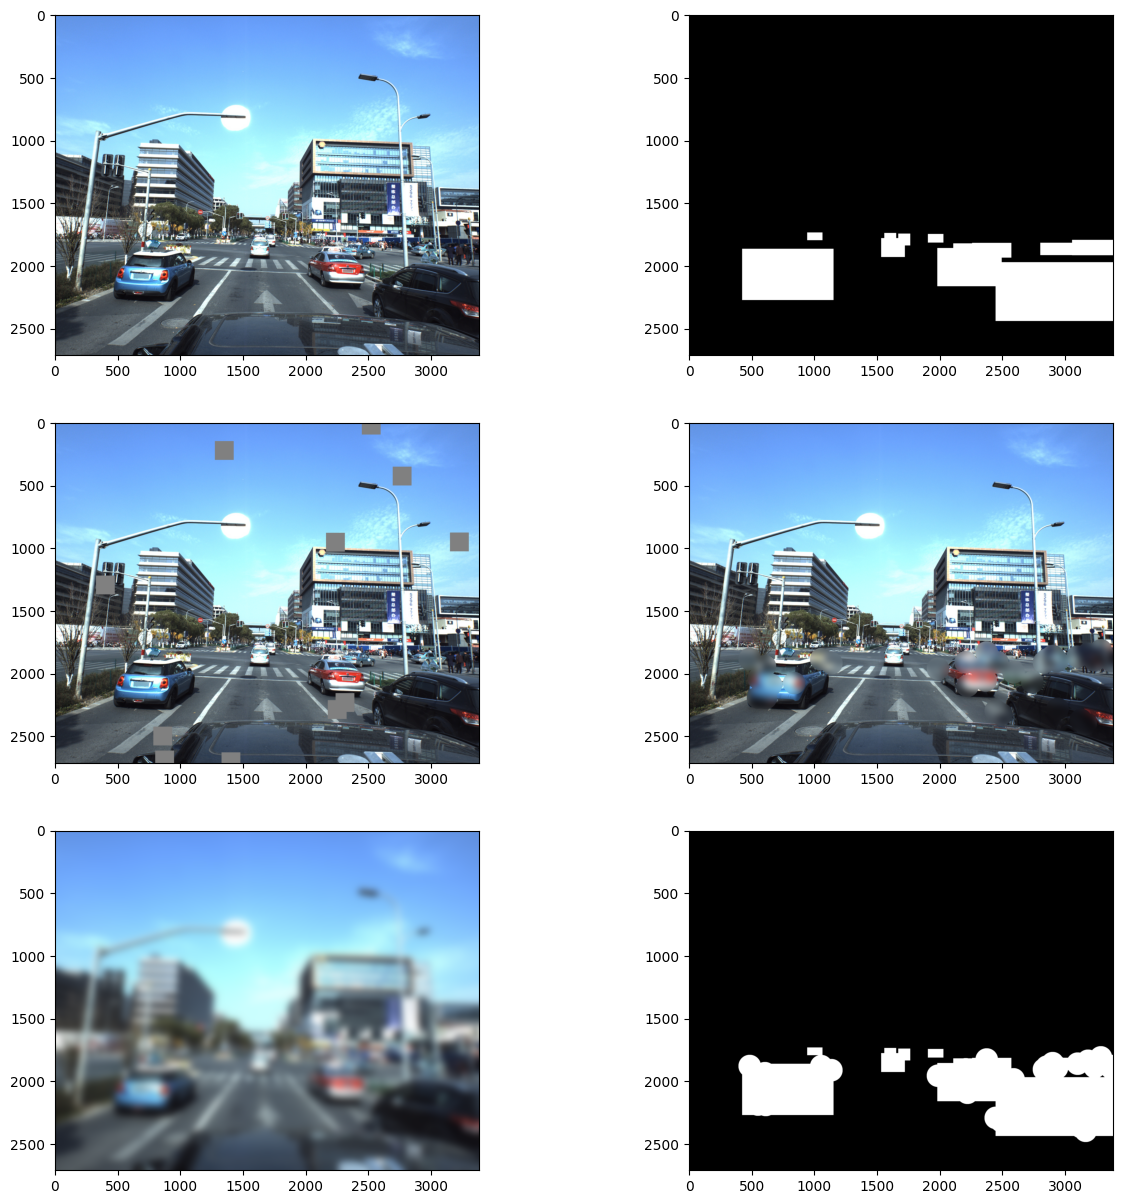

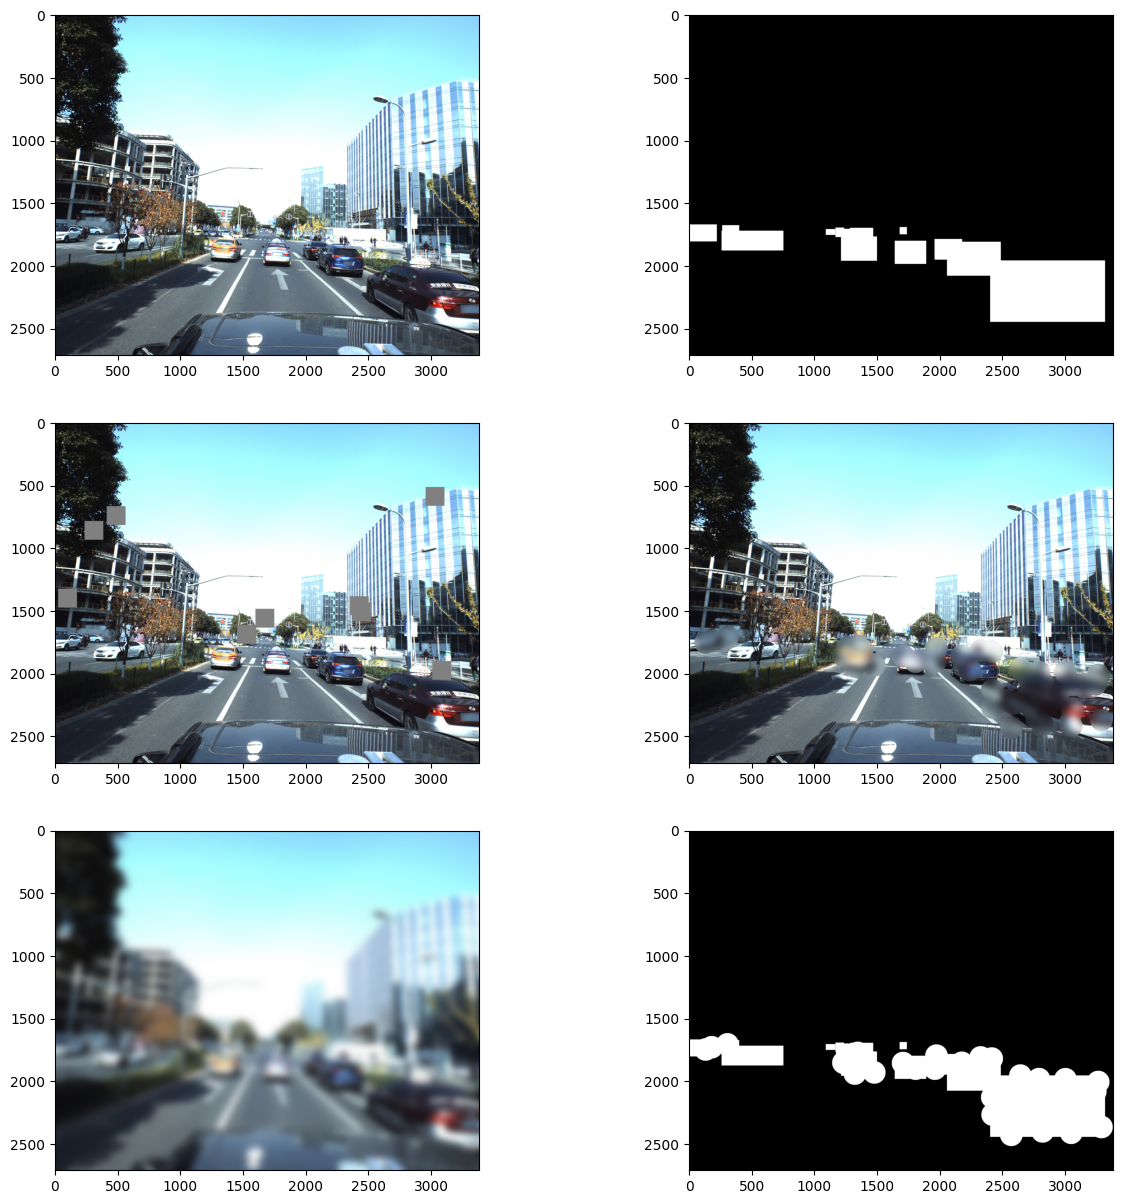

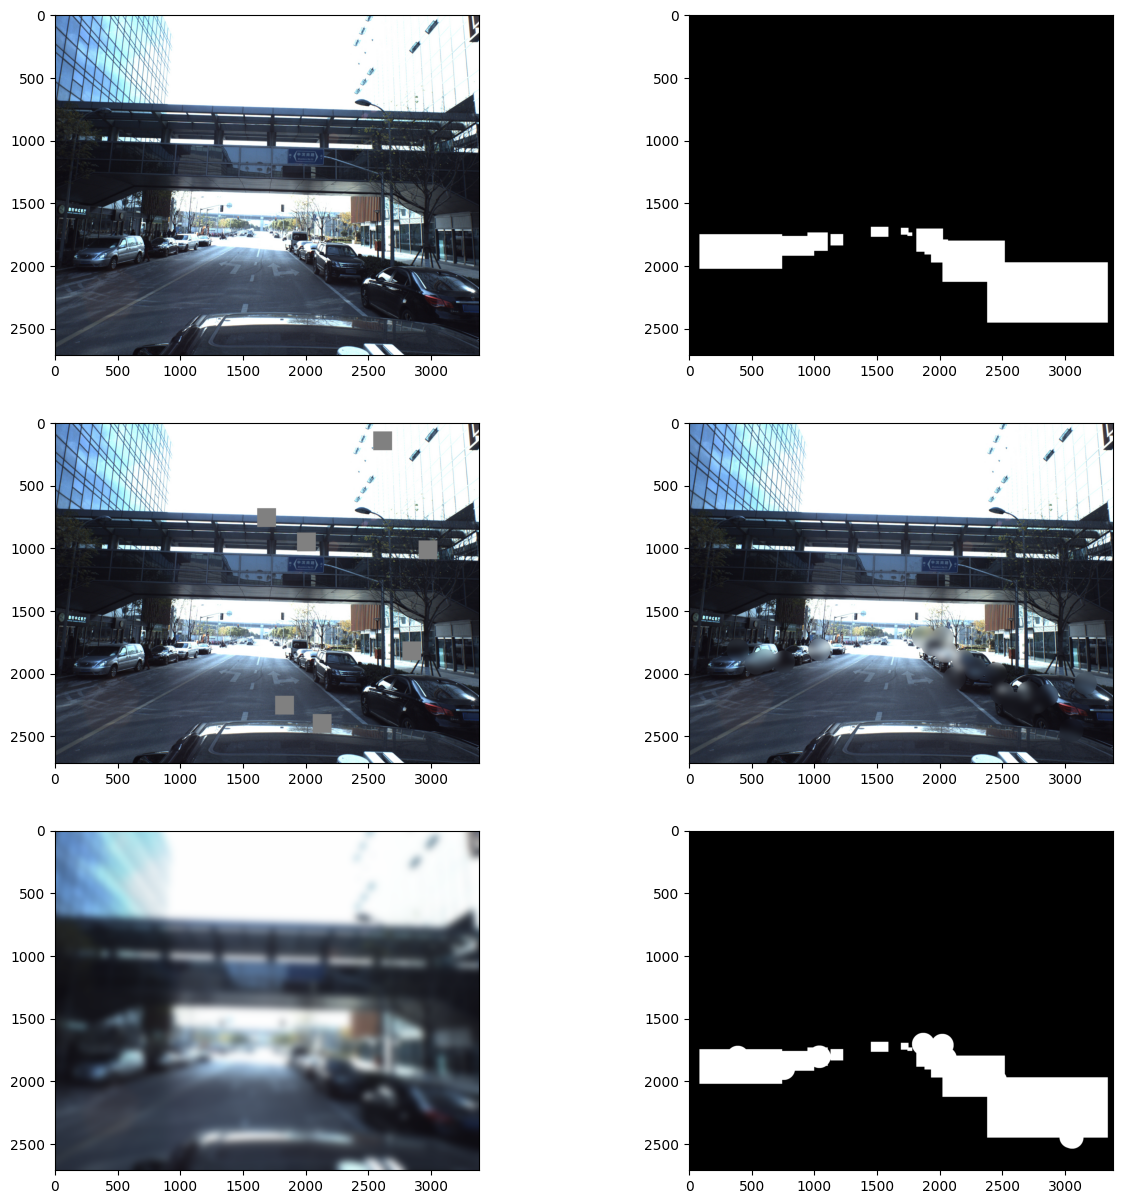

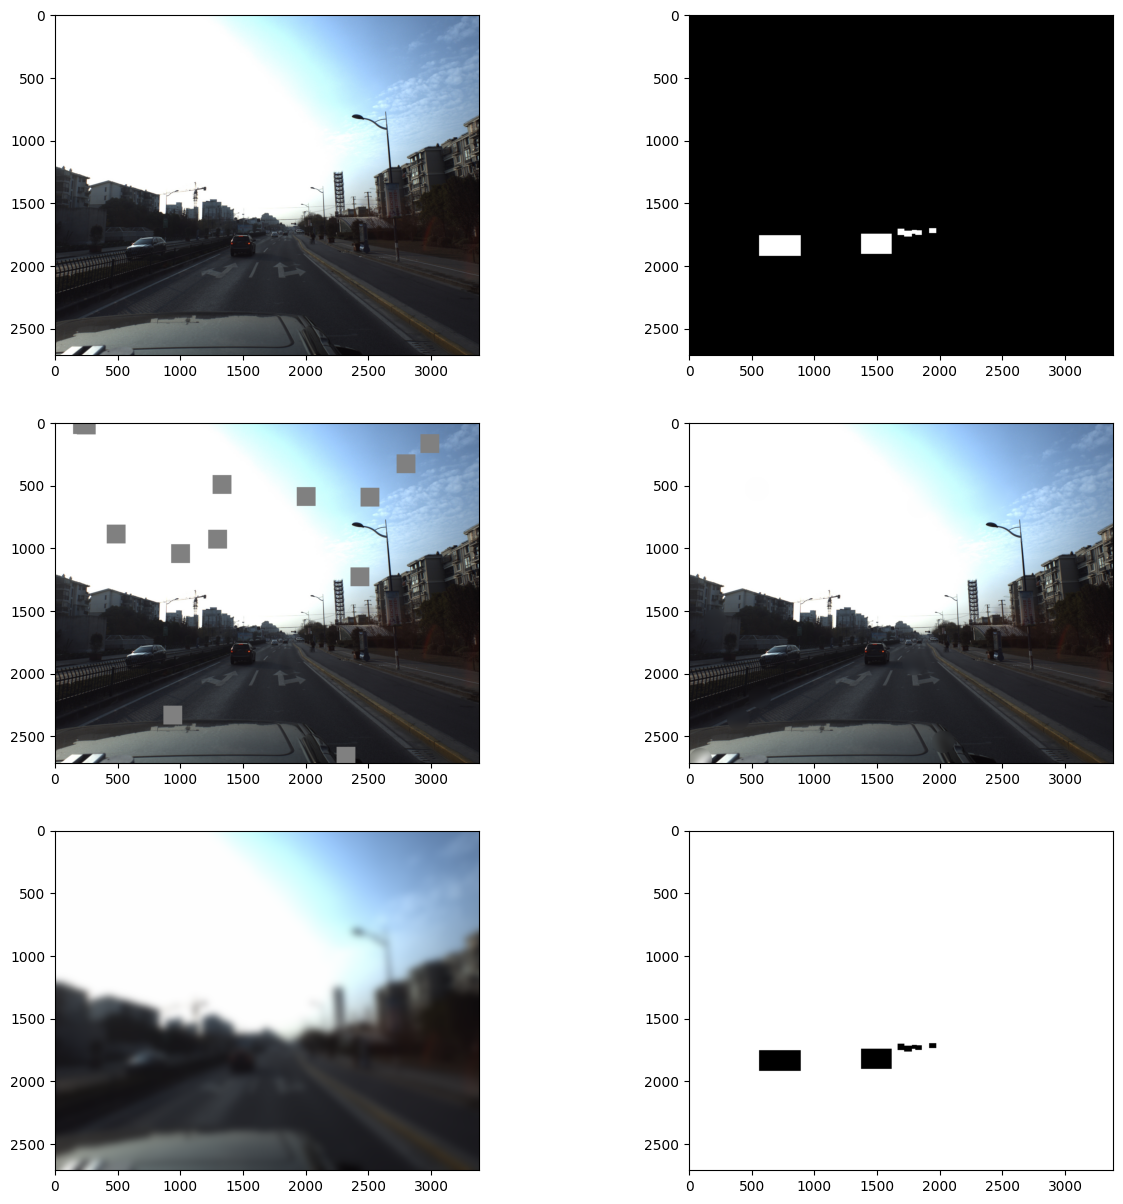

In [3]:
import cv2
from PIL import Image
from skimage.filters import gaussian

random.seed(1011)
def apply_grid_masking(img, segm):
    img = img.copy()
    RECT_SIZE = 25*6
    MAX_RECT = 15
    nb_mask = random.randint(0,MAX_RECT)
    fill_value = np.array([128, 128, 128])

    indices_hor = random.choices(list(range(img.shape[1])),k=nb_mask)
    indices_ver = random.choices(list(range(img.shape[0])),k=nb_mask)

    RECT_SIZE = RECT_SIZE//2
    for i,j in zip(indices_hor, indices_ver):
        a = max(i - RECT_SIZE, 0)
        b = max(j - RECT_SIZE, 0)
        c = min(i + RECT_SIZE, img.shape[1])
        d = min(j + RECT_SIZE, img.shape[0])
        img[b:d,a:c] = fill_value

    return img
  
def get_source_in_mask(mask, nb_blur_source):
    coordinates = np.transpose(mask.nonzero())
    samples = random.choices(np.arange(len(coordinates)), k=nb_blur_source)
    return coordinates[samples,:]

def generate_image_segmentation(img, segm):
  NB_MAX_SOURCE = 50
  nb_blur_source = random.randint(0,NB_MAX_SOURCE) 
  blur_radius = 15*6
  blurred_img = (gaussian(img, sigma=30,channel_axis=2)*255).astype(np.uint8)
  sources = get_source_in_mask(segm, nb_blur_source)
  mask_2 = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
  for s in sources:
    mask_2 = cv2.circle(mask_2, (s[1], s[0]), blur_radius, [255,255,255], -1)
    segm = cv2.circle(segm, (s[1], s[0]), blur_radius, 1, -1)
  
  out = np.where(mask_2==255, blurred_img, img)
  return out, blurred_img, mask_2,segm

def apply_blur_masking(img, segm):
  if random.random() < 0.5:
    # Blur the cars
    segm = segm.astype(np.uint8)
  else:
    # blur the background
    segm = (segm==0).astype(np.uint8)
  return generate_image_segmentation(img, segm)


for path in sample_imgs: 
  img = Image.open(os.path.join(img_folder,path))
  img = np.asarray(img)
  segm = np.zeros(img.shape[:2])

  offset = 10
  for anotation in targets[path]:
      a,b,c,d = anotation['bbox']
      a = max(a - offset, 0)
      b = max(b - offset, 0)
      c = min(a+c + offset, img.shape[1])
      d = min(b+d + offset, img.shape[0])
      segm[b:d,a:c] = 1

  grid = apply_grid_masking(img, segm)
  blur, blurred, circle,segm_n = apply_blur_masking(img, segm)

  fig, axs = plt.subplots(3,2,figsize=(15,15))
  axs[0,0].imshow(img)
  axs[0,1].imshow(segm,cmap="gray")
  axs[1,0].imshow(grid)
  axs[1,1].imshow(blur)
  axs[2,0].imshow(blurred)
  axs[2,1].imshow(segm_n,cmap="gray")
  plt.plot()
  print()
